In [11]:
# Setup the library
import pyrogue.utilities.fileio as fileio
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import struct
from scipy.stats import norm
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import datetime
import pandas as pd
import glob
import re
top_level=f'{os.getcwd()}/..'

In [128]:
def datfile(filename):
    # Waveforms variables to be filled 
    ampFault = { i : []  for i in range(4) }  
    xPosFault = []
    yPosFault = []
    qBunchFault = []
    recordtime = []
    
    # Open the .dat file
    with fileio.FileReader(files=filename) as fd:
        i=0
        # Loop through the file data
        for header,data in fd.records():
    
            # Check if there is a 8-byte header in the frame
            if (header.flags==0):
                hdrOffset = 8
                hdr = struct.unpack("<d", data[:8])[0]
                timestamp = time.localtime(hdr)
                # Define the desired format string (replace with your preferred format)
                # Some common format specifiers:
                # %Y - Year with century
                # %m - Month as a decimal number (01-12)
                # %d - Day of the month as a decimal number (01-31)
                # %H - Hour in 24-hour format (00-23)
                # %M - Minute (00-59)
                # %S - Second (00-59)
                formatted_time = time.strftime('%Y-%m-%d %H:%M:%S', timestamp)
                #print( f'CH={header.channel}: Event Timestamp in human-readable format: {formatted_time}' )
                if i%4==0:
                    recordtime.append(formatted_time)
                i+=1
            else:
                hdrOffset = 0
                print( 'No timestamp header detected' )
            
            # Check for error in frame
            if (header.error>0):
                # Look at record header data
                print(f"Processing record. Total={fd.totCount}, Current={fd.currCount}")
                print(f"Record size    = {header.size}")
                print(f"Record channel = {header.channel}")
                print(f"Record flags   = {header.flags:#x}")
                print(f"Record error   = {header.error:#x}")
    
            # Check if AMP Fault waveform
            elif (header.channel < 16) and (header.channel >= 12):
                ampFault[header.channel-12].append(data[hdrOffset:].view(np.int16))
    
            # Check if AMP Live waveform
            elif header.channel == 24:
                fpData = data[hdrOffset:].view(np.float32)
                fpDataLen = len(fpData)
                xPosFault.append(   fpData[0:(fpDataLen*3)+0:3] ) 
                yPosFault.append(   fpData[1:(fpDataLen*3)+1:3] )
                qBunchFault.append( fpData[2:(fpDataLen*3)+2:3] )
            
            # Else undefined stream index
            else:
                print( f'UNDEFINED DATA STREAM[{header.channel}]!!!')
    return ampFault, recordtime

In [15]:
filename=[]
def process_dat_file(dat_file_path):
    # ここに.datファイルに対する処理を記述する
    #print("Processing:", dat_file_path)
    filename.append(dat_file_path)
    #parse_and_plot(dat_file_path)

# ディレクトリのパス
directory_path = "/mnt/SBOR/ZCU111/"

# 指定した日付
specified_date = datetime(2024, 6, 11, 16, 0, 0)
end_date = datetime(2024, 6, 18, 16, 0, 0)

# ディレクトリ内のすべての.datファイルに対して処理を実行
for dat_file in glob.glob(os.path.join(directory_path, "*.dat")):
    # ファイル名から日付部分を抽出
    match = re.search(r'data_(\d{8})_(\d{6})\.dat', dat_file)
    if match:
        file_datetime = datetime.strptime(match.group(1) + match.group(2), '%Y%m%d%H%M%S')
        # 指定した日付以降のファイルのみ処理する
        if file_datetime >= specified_date:
            process_dat_file(dat_file)

In [16]:
filename

['/mnt/SBOR/ZCU111/data_20240612_034507.dat',
 '/mnt/SBOR/ZCU111/data_20240616_191459.dat',
 '/mnt/SBOR/ZCU111/data_20240614_050937.dat',
 '/mnt/SBOR/ZCU111/data_20240611_235703.dat',
 '/mnt/SBOR/ZCU111/data_20240613_080746.dat',
 '/mnt/SBOR/ZCU111/data_20240612_232040.dat',
 '/mnt/SBOR/ZCU111/data_20240616_033346.dat',
 '/mnt/SBOR/ZCU111/data_20240619_150020.dat',
 '/mnt/SBOR/ZCU111/data_20240619_083947.dat',
 '/mnt/SBOR/ZCU111/data_20240619_174032.dat',
 '/mnt/SBOR/ZCU111/data_20240612_071607.dat',
 '/mnt/SBOR/ZCU111/data_20240618_061745.dat',
 '/mnt/SBOR/ZCU111/data_20240618_130315.dat',
 '/mnt/SBOR/ZCU111/data_20240614_171544.dat',
 '/mnt/SBOR/ZCU111/data_20240616_200003.dat',
 '/mnt/SBOR/ZCU111/data_20240612_135958.dat',
 '/mnt/SBOR/ZCU111/data_20240613_220901.dat',
 '/mnt/SBOR/ZCU111/data_20240612_095451.dat',
 '/mnt/SBOR/ZCU111/data_20240617_011527.dat',
 '/mnt/SBOR/ZCU111/data_20240615_192810.dat',
 '/mnt/SBOR/ZCU111/data_20240615_101224.dat',
 '/mnt/SBOR/ZCU111/data_20240612_0

In [62]:
current=[]
ch0=[]
ch1=[]
ch2=[]
ch3=[]


for i in filename:
    ampFault, recordtime=datfile(i)
    eventnum=0
    
    def bunchindex(threshold,waveform):
        bunch_index=[]
    
        for i in range(2560):
            if max(ampFault[0][eventnum][i:i+50])<2000:
                start=i+50
                break
        print(start)
        for i in range(5120):
            if waveform[start+i]>threshold:
                bunch_index.append(start+i)
    
        if len(bunch_index)==0:
            print("data is invalid")
            return bunch_index
    
        print(f'Nbunch={len(bunch_index)}')
        return np.array(bunch_index)
    
        
    bunch_index=bunchindex(500,ampFault[0][eventnum])
    if len(bunch_index)==0:
        print("data is invalid")
        continue

    # CSVファイルのパス
    csv_file_path = '/home/nomaru/Downloads/tL1CRpJc.csv'
    
    # CSVファイルを読み込む
    df = pd.read_csv(csv_file_path, header=None, names=['datetime', 'value'])
    df=df.drop(0)
    
    # datetime列をdatetime型に変換
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y/%m/%d %H:%M:%S.%f')
    
    target_time = datetime.strptime(recordtime[0], '%Y-%m-%d %H:%M:%S')

    # 指定された日時との差を計算
    df['time_diff'] = (df['datetime'] - target_time).abs()
    
    # 最も近い日時の行を取得
    nearest_row = df.loc[df['time_diff'].idxmin()]

    if float(nearest_row['value'])>=400:
        current.append(float(nearest_row['value']))
        
        ch0.append(np.mean(ampFault[0][eventnum][bunch_index]))
        ch1.append(np.mean(ampFault[1][eventnum][bunch_index]))
        ch2.append(np.mean(ampFault[2][eventnum][bunch_index]))
        ch3.append(np.mean(ampFault[3][eventnum][bunch_index]))

    
        


1273
Nbunch=2249
1465
Nbunch=2249
152
Nbunch=2249
2412
Nbunch=2249
985
Nbunch=2249
50
data is invalid
data is invalid
1756
Nbunch=2249
2044
Nbunch=393
2156
Nbunch=2249
50
data is invalid
data is invalid
140
Nbunch=2249
489
Nbunch=2249
50
data is invalid
data is invalid
50
Nbunch=303
2396
Nbunch=2249
50
data is invalid
data is invalid
2329
Nbunch=2249
50
data is invalid
data is invalid
1756
Nbunch=2249
1308
Nbunch=2249
50
Nbunch=2249
1945
Nbunch=2249
1372
Nbunch=2249
50
Nbunch=385
50
data is invalid
data is invalid
50
data is invalid
data is invalid
50
data is invalid
data is invalid
761
Nbunch=2249
1004
Nbunch=2249
50
data is invalid
data is invalid
1273
Nbunch=2249
50
data is invalid
data is invalid
50
data is invalid
data is invalid
1049
Nbunch=2249
50
data is invalid
data is invalid
50
data is invalid
data is invalid
50
data is invalid
data is invalid
1020
Nbunch=2249
50
data is invalid
data is invalid
1977
Nbunch=2249
1381
Nbunch=1218
825
Nbunch=2249
1548
Nbunch=2249
50
data is inv

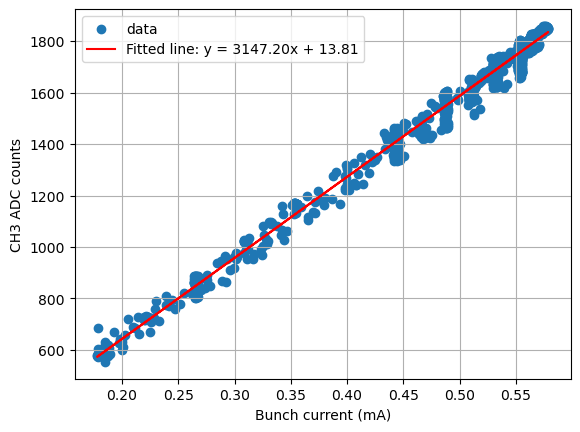

In [119]:
bunchcurrent=np.array(current)/2249
count=np.array(ch0)/4

plt.scatter(bunchcurrent,count,label='data')
coefficients = np.polyfit(bunchcurrent, count, 1)  # 一次の多項式（直線）をフィット
slope, intercept = coefficients

y_fit = slope * bunchcurrent + intercept

# フィットした直線をプロット
plt.plot(bunchcurrent, y_fit, color='red', label=f'Fitted line: y = {slope:.2f}x + {intercept:.2f}')

# ラベルと凡例を追加
plt.xlabel("Bunch current (mA)")
plt.ylabel("CH3 ADC counts")
plt.legend()
plt.grid()
#plt.savefig("ch3.png",dpi=200)
plt.show()

1


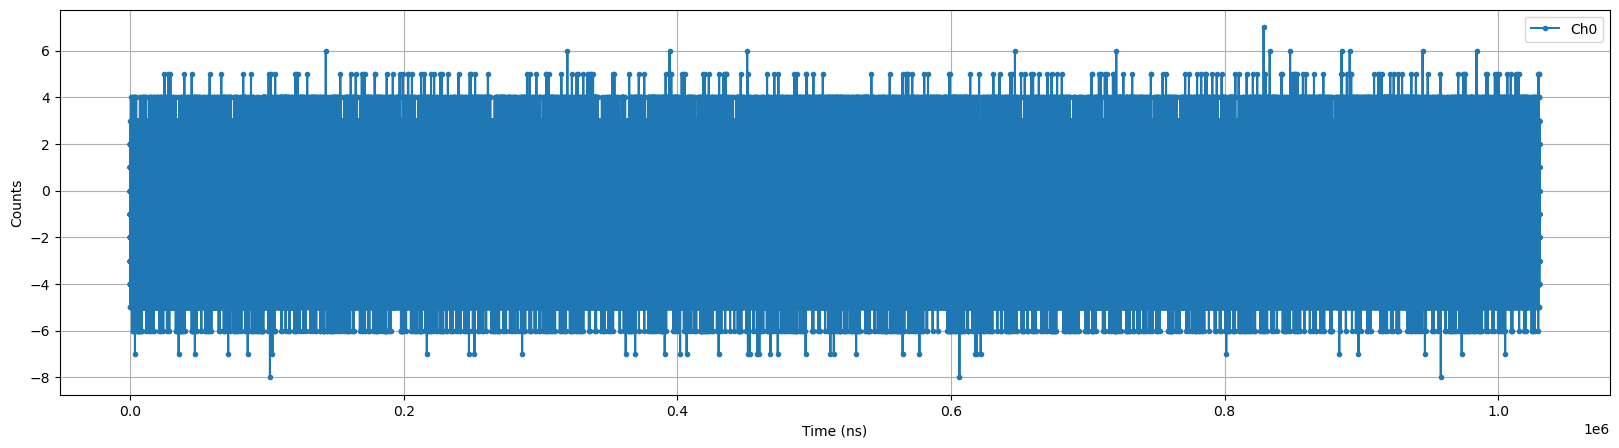

In [176]:
ampFault,recordtime=datfile("/mnt/SBOR/ZCU111/data_20240620_153103.dat")

print(len(recordtime))
eventnum=0
size = len(ampFault[0][eventnum])

#print(recordtime[eventnum])
timeBin = 1.0/(0.509) # Unit of ns for 4.072 GSPS
timeSteps = np.linspace(0, timeBin*(size-1), num=size)

# Plot the Waveform Full Scale
plt.figure(figsize=(20,5))
start=4646
plt.plot(timeSteps,ampFault[0][eventnum]//16,label="Ch0",marker='o',markersize=3)
#plt.plot(timeSteps,ampFault[1][eventnum],label="Ch1",marker='o',markersize=3)
#plt.plot(timeSteps,ampFault[2][eventnum],label="Ch2",marker='o',markersize=3)
#plt.plot(timeSteps,ampFault[3][eventnum],label="Ch3",marker='o',markersize=3)
plt.xlabel("Time (ns)")
plt.ylabel("Counts")
#plt.xlim(1020000,1021000)
plt.legend()
plt.grid()

In [178]:
print(np.std(ampFault[1][eventnum])/16)

2.1690932242120153


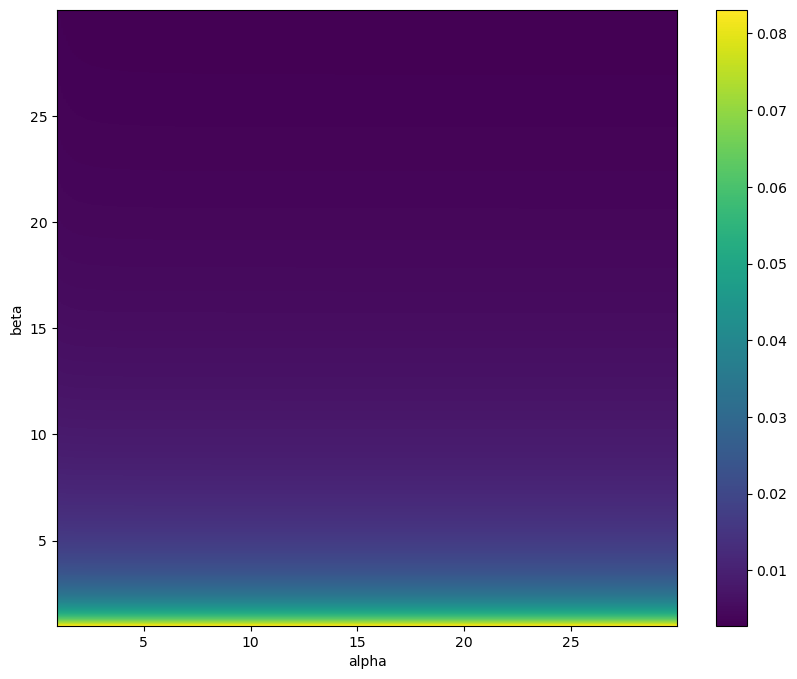

In [204]:
alpha_=np.arange(1,30,0.1)
beta_=np.arange(1,30,0.01)
alpha,beta=np.meshgrid(alpha_,beta_)

d=0
c=0.5

error=0.01897/c*((2.19/beta)**2+((31+d)*1.05/874/alpha)**2)**0.5
plt.figure(figsize=(10,8))
plt.pcolormesh(alpha,beta,error,norm=)
plt.colorbar()
plt.xlabel("alpha")
plt.ylabel("beta")
plt.show()

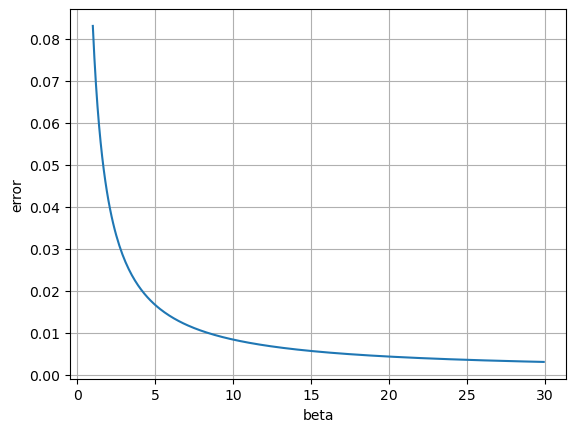

In [209]:
alpha=1
beta=np.arange(1,30,0.1)

d=0
c=0.5

error=0.01897/c*((2.19/beta)**2+((31+d)*1.05/874/alpha)**2)**0.5

plt.plot(beta,error)
plt.grid()
#plt.yscale('log')
plt.xlabel('beta')
plt.ylabel('error')
plt.show()